In [1]:
# import autoreload
# ?autoreload

%load_ext autoreload
%autoreload 2
import torch
from common import sanitize
# import torch.nn as nn
# torch.nn.modules.module.Module._call_impl = _call_impl2
# torch.nn.Module._call_impl=_call_impl2
# nn.Module._call_impl=_call_impl2


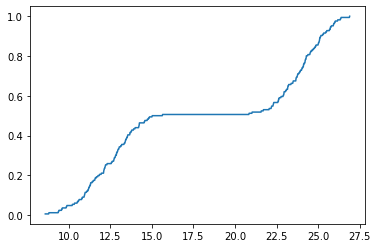

In [15]:
import numpy as np
import matplotlib.pyplot as plt

data =[
13.41831753, 14.24257614, 13.67530797, 13.38531535, 9.622475346, 11.76511494, 11.95523344, 15.0106918, 14.53941124, 9.896657452, 11.27928495, 13.53076265, 13.90819157, 13.5536826, 14.58643606, 13.67597702, 12.90547826, 12.9415645, 10.79263019, 14.23242467, 15.63687381, 9.408300147, 12.1867698, 13.1948617, 10.81807992, 13.75939787, 12.30528043, 11.24980357, 12.55818014, 14.79584199, 10.96504181, 13.45818302, 12.88396798, 8.812445908, 14.8578155, 13.78856213, 12.73506788, 12.97733226, 13.40098183, 12.82261416, 12.1059271, 11.58146691, 11.84358462, 14.00260615, 9.38656165, 13.04141822, 13.02696849, 14.20621092, 10.51214713, 12.74456601, 14.24943142, 10.98496233, 10.34253439, 14.72844488, 10.95271328, 13.5010997, 22.57372552, 23.66317159, 24.16003943, 24.2867595, 25.32810764, 24.87822138, 24.03613058, 25.12136086, 23.7589534, 22.65240191, 23.66351436, 23.21483438, 24.78400709, 25.16263972, 23.68989239, 24.2578122, 25.73911589, 21.70984586, 23.37238573, 25.44858723, 22.76278729, 24.62949059, 23.4938048, 24.21164685, 25.7274449, 24.2078517, 23.76961718, 26.89444913, 26.17990225, 22.31571423, 20.8336373, 21.02211555, 22.6171758, 24.11202282, 24.12223916, 25.92397825, 24.82692423, 22.19702871, 23.48329294, 24.49791812, 22.28787792, 22.33069863, 25.51405369, 25.09606256, 22.92909756, 25.78642237, 24.55631747, 26.01907462, 21.57647166, 25.02130319, 25.99634151, 23.89533622, 26.3776954, 23.73957306, 22.18576707, 24.27718969, 23.93939589, 25.08293872, 26.33969077, 23.04702086, 25.26835598, 24.7022833, 25.06700962, 22.05519116, 25.6808416, 22.8990797, 22.62404626, 23.84427772, 24.52220782, 25.0517399, 24.99957389, 25.9088608, 22.95207229, 24.23137213, 23.19155061, 22.95097839, 23.0994308, 24.09090818, 23.17005974, 24.37553465, 23.167263, 24.01868985, 11.42106254, 11.21360238, 12.22437928, 11.19759844, 13.33692235, 12.7059425, 11.48180572, 12.12343311, 12.2020964, 12.14323476, 9.84774572, 13.13033881, 12.6139495, 11.67639914, 11.32859897, 10.62824764, 10.93780054, 11.07962112, 12.10391571, 10.21561503, 11.31835281, 11.16316732, 11.59250807, 8.582846796, 12.80075, 9.584382849, 10.57620628, 12.88112682]
num_bins = 50
counts, bin_edges = np.histogram (data, bins=1000)
cdf = np.cumsum (counts)
f = plt.figure()
plt.plot (bin_edges[1:], cdf/cdf[-1])
plt.show()

In [16]:
f.savefig("foo.pdf", bbox_inches='tight')


In [90]:

import time
from transformers import AutoModel
from transformers import AutoConfig
import torch
from torch import nn
torch.set_grad_enabled(False)

In [91]:
from calibrate_e_ml import get_module_info
from calibrate_e_ml import print_info

from cg.node import construct_aggregation_graph

In [92]:
seq_len = 100
bs = 4
input_ids = torch.randint(1000, size=(bs, seq_len), dtype=torch.long, device='cpu')
cuda_exist = torch.cuda.is_available()
device = torch.device("cuda" if cuda_exist else "cpu")

In [ ]:
model_name = "prajjwal1/bert-tiny"
information = get_module_info(model_name, bs, seq_len, device, 'module')
print_info(information)

In [ ]:
import inspect
from run_level_exp import get_model_flops_mem_bytes, wrapped_partial

In [ ]:
sel_attn = information['BertSelfAttention'][0]
fn = sel_attn['module']
fi = sel_attn['inputs']
fi_kwargs = sel_attn['in_kwargs']

fn_fwd = fn.forward
#  unify fi and fi_kwargs
fn_args = inspect.getfullargspec(fn_fwd).args
fill_args = dict()
fi_args = fn_args[1:1 + len(fi)]
ti = []
for fi_k, fi_v in zip(fi_args, fi):
    if isinstance(fi_v, torch.Tensor):
        ti.append(fi_v)
    else:
        fill_args[fi_k] = fi_v
for k, v in fi_kwargs.items():
    if isinstance(v, torch.Tensor):
        ti.append(v)
    else:
        fill_args[k] = v
# wrap forward into traceable fn (only tensor args)
# https://github.com/pytorch/pytorch/issues/14455#issuecomment-445962680
fn.forward = wrapped_partial(fn.forward, **fill_args)

In [ ]:
flops, mem_bytes = get_model_flops_mem_bytes(fn, ti, 'BertEncoder')
print(flops/1e6, mem_bytes/1024/1024)

In [ ]:
model_name = "distilbert-base-uncased"
distilbert_information = get_module_info(model_name, bs, seq_len, device, 'module')
print_info(distilbert_information)

In [ ]:
get_non_parametric_ml_op(distilbert_information)

In [ ]:
model_name = "bert-base-uncased"
bert_information = get_module_info(model_name, bs, seq_len, device, 'module')
print_info(bert_information)

In [ ]:
get_non_parametric_ml_op(bert_information['BertSelfAttention'])

In [ ]:
model_name = "roberta-base"
roberta_information = get_module_info(model_name, bs, seq_len, device, 'module')
print_info(roberta_information)

In [ ]:
get_non_parametric_ml_op(roberta_information['RobertaSelfAttention'])

In [93]:
# for k, info in information.items():
#     for infoi in info:
#         ii = infoi['inputs']
#         if isinstance(ii, dict):
#             print(type(ii), infoi['name'],  {iik:v.shape if isinstance(v, torch.Tensor) else v for iik, v in ii.items()})
#         elif isinstance(ii, tuple):
#             print(type(ii), infoi['name'],  [v.shape if isinstance(v, torch.Tensor) else v for v in ii])
#         else:
#             print(type(ii), 'todo', k, infoi)
#         print()
from calibrate_e_ml import get_module_info
from calibrate_e_ml import print_info

model_name = "gpt2"
information = get_module_info(model_name, 32, 32, device, 'module')
print_info(information)

Attention 12
<class 'dict'> h.0.attn:Attention {'layer_past': None, 'attention_mask': None, 'head_mask': None, 'use_cache': True, 'output_attentions': False}
<class 'tuple'> h.0.attn:Attention [torch.Size([32, 32, 768])]

MLP 12
<class 'tuple'> h.0.mlp:MLP [torch.Size([32, 32, 768])]

Block 12
<class 'dict'> h.0:Block {'layer_past': None, 'attention_mask': None, 'head_mask': None, 'encoder_hidden_states': None, 'encoder_attention_mask': None, 'use_cache': True, 'output_attentions': False}
<class 'tuple'> h.0:Block [torch.Size([32, 32, 768])]



In [ ]:
get_non_parametric_ml_op(mobilebert_information['MobileBertSelfAttention'])

In [ ]:
model_name = "prajjwal1/bert-tiny"
information = get_module_info(model_name, bs, seq_len, device, 'module')
print_info(information)

In [ ]:
import torch
from torch import nn
from transformers import AutoConfig
from transformers import AutoModel
from transformers import modeling_utils

def is_ml_operation(module):
    """
    This function checks if any given module is of a type that
    we want to analyse for E_ML operations
    """

    e_ml_operations = {nn.Linear, nn.LayerNorm, nn.Embedding, nn.BatchNorm1d,
                       nn.Conv1d, nn.MaxPool1d, nn.AvgPool1d, nn.LSTM, nn.Tanh,
                       modeling_utils.Conv1D}

    for e_ml_op in e_ml_operations:
        if isinstance(module, e_ml_op):
            return True
    return False

config = AutoConfig.from_pretrained(model_name)
config.torchscript = True
model=AutoModel.from_config(config).eval()

In [ ]:
model.config

In [ ]:
for name, module in model.named_modules():
    if not name:
        continue
    if not is_ml_operation(module):
        print(f'{name}:{module.__class__.__name__}')
#         print(f'\t{module}\n')

In [ ]:

def get_non_parametric_ml_ops(model, input_ids):
    non_param_scopes = {name for name, module in model.named_modules() if not is_ml_operation(module)}
    trace = torch.jit.trace(model, input_ids)
    trace_graph = trace.inlined_graph
    graph, op_data_types = construct_aggregation_graph(trace_graph, fname)
    sigs = set()
    for node in graph.nodes:
        if node.op == 'aten::softmax':
            sig = f'op=softmax,flops={node.flops},mem_bytes={node.mem_bytes}'
            if sig not in sigs:
                print(node)
                sigs.add(sig)
        if node.op == 'aten::matmul' and node.scope in non_param_scopes:
            sig = f'op=matmul,flops={node.flops},mem_bytes={node.mem_bytes}'
            if sig not in sigs:
                print(node)
                sigs.add(sig)

In [ ]:
from cg.node import construct_aggregation_graph
from calibrate_e_ml import get_non_parametric_ml_ops
model_name = "prajjwal1/bert-tiny"
# "google/mobilebert-uncased" "bert-base-uncased" "distilbert-base-uncased" "roberta-base" "prajjwal1/bert-tiny"
config = AutoConfig.from_pretrained(model_name)
config.torchscript = True
model=AutoModel.from_config(config).eval()
np_info = get_non_parametric_ml_ops(model, input_ids)

In [ ]:
print_info(np_info)

In [ ]:
for node in trace_graph.nodes():
    if node.kind() == 'prim::Constant':
#         print(node)
        print(node.outputs().toIValue())

In [ ]:
config = AutoConfig.from_pretrained("google/mobilebert-uncased")
config.torchscript = True
model=AutoModel.from_config(config).eval()
get_non_parametric_ml_ops(model, input_ids)

In [ ]:
config = AutoConfig.from_pretrained("bert-base-uncased")
config.torchscript = True
model=AutoModel.from_config(config).eval()
get_non_parametric_ml_ops(model, input_ids)

In [ ]:
config = AutoConfig.from_pretrained("distilbert-base-uncased")
config.torchscript = True
model=AutoModel.from_config(config).eval()
get_non_parametric_ml_ops(model, input_ids)

In [ ]:
config = AutoConfig.from_pretrained("roberta-base")
config.torchscript = True
model=AutoModel.from_config(config).eval()
get_non_parametric_ml_ops(model, input_ids)

In [1]:
import bisect
import json
import pandas as pd
import numpy as np
from pathlib import Path
from common import sanitize

pd.set_option('display.float_format', '{:.6f}'.format)
def is_float(x):
    try:
        float(x)
    except ValueError:
        return False
    return True

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [ ]:
res_names = ['cpu', 'mem', 'gpu', 'gpu_mem']

feature_names = ['batch_size', 'seq_len', 'flops',
                 'mem_bytes'] + \
                ['times_mean', 'times_std',
                 'gpu_power_mean', 'gpu_power_std', 'repeats',
                 'energy_mean', 'energy_std',
                 'level_name', 'model_name'] + res_names + [f'{k}_std' for k in res_names] 

def process_record(energy, prof_info, res, feature_values,
                   model_name, bs, runs, seq_len):
    res_np = res.to_numpy()
    res_t = res_np[:, 0]
    energy_np = energy.to_numpy()
    energy_t = energy_np[:, 0]
    for prof_item in prof_info:
        gpu_power_runs = []
        energy_runs = []
        times_runs = []
        res_runs = {k: [] for k in res_names}
        repeats = prof_item['repeats']
        for r in range(1, runs + 1):
            start_r = prof_item[f'start_{r}']
            end_r = prof_item[f'end_{r}']
            times_runs.append(end_r - start_r)

            res_s = bisect.bisect_right(res_t, start_r)
            res_e = bisect.bisect_right(res_t, end_r)
            res_r = res[res_s:res_e]
            for rn in res_names:
                res_runs[rn].append(res_r[rn].mean())
            gpu_power_r = res_r['gpu_power'].sum()
            gpu_power_runs.append(gpu_power_r)

            e_s = bisect.bisect_right(energy_t, start_r)
            e_e = bisect.bisect_right(energy_t, end_r)
            energy_r = energy[e_s:e_e]['value'].div(repeats).sum()
            energy_runs.append(energy_r)

        times_mean = np.mean(times_runs)
        times_std = np.std(times_runs) / times_mean * 100
        gpu_power_mean = np.mean(gpu_power_runs)
        gpu_power_std = np.std(gpu_power_runs) / gpu_power_mean * 100
        energy_mean = np.median(energy_runs)
        energy_std = np.std(energy_runs) / energy_mean * 100
        for rn in res_names:
            feature_values[rn].append(np.mean(res_runs[rn]))
            rn_std = np.std(res_runs[rn]) / np.mean(res_runs[rn]) * 100
            feature_values[f'{rn}_std'].append(rn_std)

        flops = prof_item['flops'] / 1e6
        mem_bytes = prof_item['mem_bytes'] / 1024 / 1024
        feature_values['batch_size'].append(bs)
        feature_values['seq_len'].append(seq_len)
        feature_values['repeats'].append(repeats)
        feature_values['energy_mean'].append(energy_mean)
        feature_values['energy_std'].append(energy_std)
        feature_values['gpu_power_mean'].append(gpu_power_mean)
        feature_values['gpu_power_std'].append(gpu_power_std)
        feature_values['flops'].append(flops)
        feature_values['mem_bytes'].append(mem_bytes)
        feature_values['times_mean'].append(times_mean)
        feature_values['times_std'].append(times_std)
        feature_values['level_name'].append(prof_item['name'])
        feature_values['model_name'].append(model_name)


In [ ]:
args=Namespace(out_dir='data/qpc', 
               models=["bert-base-uncased", "distilbert-base-uncased", "roberta-base"],
               exp_type='module', exp_name='module-exp-qpc', runs=3, 
               input_start=32, seq_step=32, input_length=160,
               batch_start=24, batch_step=8, batch_size=40, 
               )

out_dir = Path(args.out_dir)
out_dir.mkdir(parents=True, exist_ok=True)
runs = args.runs
input_start = args.input_start
input_length = args.input_length
batch_start = args.batch_start
batch_size = args.batch_size
batch_step = args.batch_step
seq_step = args.seq_step
exp_type = args.exp_type
exp_name = args.exp_name

feature_file = out_dir / f'{exp_name}_features.csv'
res_file =  out_dir / f'three-exp-res.csv'
energy_file = out_dir / f'three-exp-energy.csv'

In [ ]:

res = pd.read_csv(res_file).dropna()
res = res.apply(pd.to_numeric)

energy = pd.read_csv(energy_file, error_bad_lines=False, usecols=[0, 2]).dropna()
energy = energy[energy['value'].apply(lambda x: is_float(x))]
energy = energy[energy['timestamp'].apply(lambda x: is_float(x))]

energy['value'] = energy['value'].astype(float).div(100)
energy['timestamp'] = energy['timestamp'].astype(float)


In [ ]:
infos = []
for model_name in args.models:
    feature_values = {k: [] for k in feature_names}
    for bs in range(batch_start, batch_size, batch_step):
        for seq_len in range(input_start, input_length, seq_step):
            name_s = sanitize(model_name)
            filename = f'{name_s}_{exp_type}_r{runs}_b{bs}_i{seq_len}.json'
            prof_file = Path(out_dir) / exp_name / filename
            if not prof_file.exists():
                print(prof_file)
                continue
            with open(prof_file) as f:
                prof_info = json.load(f)
            process_record(energy, prof_info, res, feature_values,
                           model_name, bs, runs, seq_len)
    info = pd.DataFrame(data=feature_values)
    info.to_csv(feature_file)
    infos.append(info)
    print(f'{model_name} done.')

In [ ]:
bs = 32
seq_len = 256
runs = 3
model_name = "bert-base-uncased"

feature_values = {k: [] for k in feature_names}
name_s = sanitize(model_name)
filename = f'{name_s}_{exp_type}_r{runs}_b{bs}_i{seq_len}.json'
prof_file = Path(out_dir) / exp_name / filename
with open(prof_file) as f:
    prof_info = json.load(f)
process_record(energy, prof_info, res, feature_values, model_name, bs, runs, seq_len)
info = pd.DataFrame(data=feature_values)

In [2]:
pd.set_option('display.float_format', '{:.6f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [ ]:
info

In [ ]:
res.to_csv('data/jpc/res.csv')

In [ ]:
for info in infos:
    print(info.shape)

In [ ]:
ml_np_info = pd.concat(infos)
ml_np_info.dropna()
# ml_np_info.dropna().to_csv('data/jpc/ml_np_features.csv')

In [ ]:
ml_info = pd.concat(infos)
ml_info

In [ ]:
module_info = pd.concat(infos)
module_info

In [ ]:
model_info = pd.concat(infos)
model_info

In [ ]:
infos[2].dropna().sort_values('energy_std')

In [ ]:
infos[3].dropna().sort_values('energy_std')

In [33]:
out_dir = Path('data/qpc_8')
exp_name = 'model-exp-qpc'
exp_type = 'model'
model_data = pd.read_csv(out_dir / f'{exp_type}-{exp_name}_features.csv')

exp_name = 'module-exp-qpc'
exp_type = 'module'
module_data = pd.read_csv(out_dir / f'{exp_type}-{exp_name}_features.csv')

exp_name = 'ml-exp-qpc'
exp_type = 'ml'
ml_data = pd.read_csv(out_dir / f'{exp_type}-{exp_name}_features.csv')

exp_type = 'ml-np'
ml_np_data = pd.read_csv(out_dir / f'{exp_type}-{exp_name}_features.csv')


In [12]:
# model_data[['gpu_energy_mean', 'energy_mean']].plot(style=['rx-','go-'], figsize=(16, 8))

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

In [ ]:
module_data[['gpu_energy_mean', 'energy_mean']].plot(style=['rx-','go-'], figsize=(24, 8))

In [ ]:
ml_data[['gpu_energy_mean', 'energy_mean']].plot(style=['rx-','go-'], figsize=(24, 8))

In [ ]:
ml_np_data[['gpu_energy_mean', 'energy_mean']].plot(style=['rx-','go-'], figsize=(24, 8))

In [87]:
module_data.loc[module_data['model_name']=="distilbert-base-uncased"][]

2100                                embeddings:Embeddings
2101    transformer.layer.0.attention:MultiHeadSelfAtt...
2102    transformer.layer.1.attention:MultiHeadSelfAtt...
2103    transformer.layer.2.attention:MultiHeadSelfAtt...
2104    transformer.layer.3.attention:MultiHeadSelfAtt...
                              ...                        
2655                 transformer.layer.2:TransformerBlock
2656                 transformer.layer.3:TransformerBlock
2657                 transformer.layer.4:TransformerBlock
2658                 transformer.layer.5:TransformerBlock
2659                              transformer:Transformer
Name: level_name, Length: 560, dtype: object

In [58]:
# md=module_data[:75].loc[:, (module_data[:75] == 0).any(axis=0)]
# md
from sklearn import preprocessing


<ipython-input-88-3c392a503367>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md[['flops', 'times_mean', 'energy_mean']] = x_scaled
/Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


<AxesSubplot:>

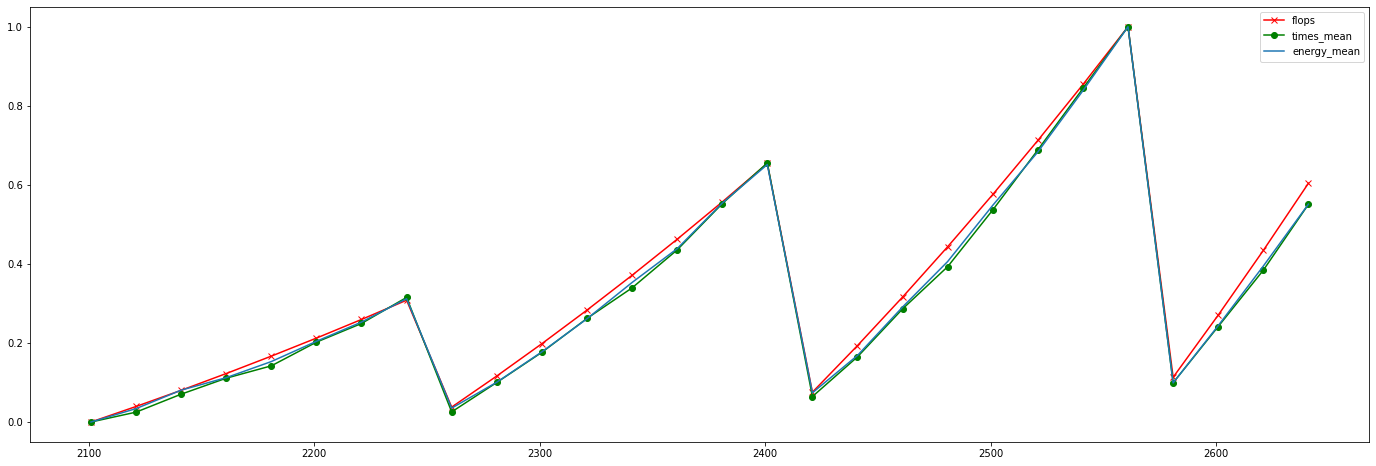

In [88]:
md=module_data.loc[module_data['level_name'] == "transformer.layer.0.attention:MultiHeadSelfAttention"]
x = md[['flops', 'times_mean', 'energy_mean']].to_numpy() #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
md[['flops', 'times_mean', 'energy_mean']] = x_scaled
md[['flops', 'times_mean', 'energy_mean']].plot(style=['rx-','go-'], figsize=(24, 8))


<ipython-input-76-e039c89a0acd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md[['flops', 'times_mean', 'energy_mean']] = x_scaled
/Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


<AxesSubplot:>

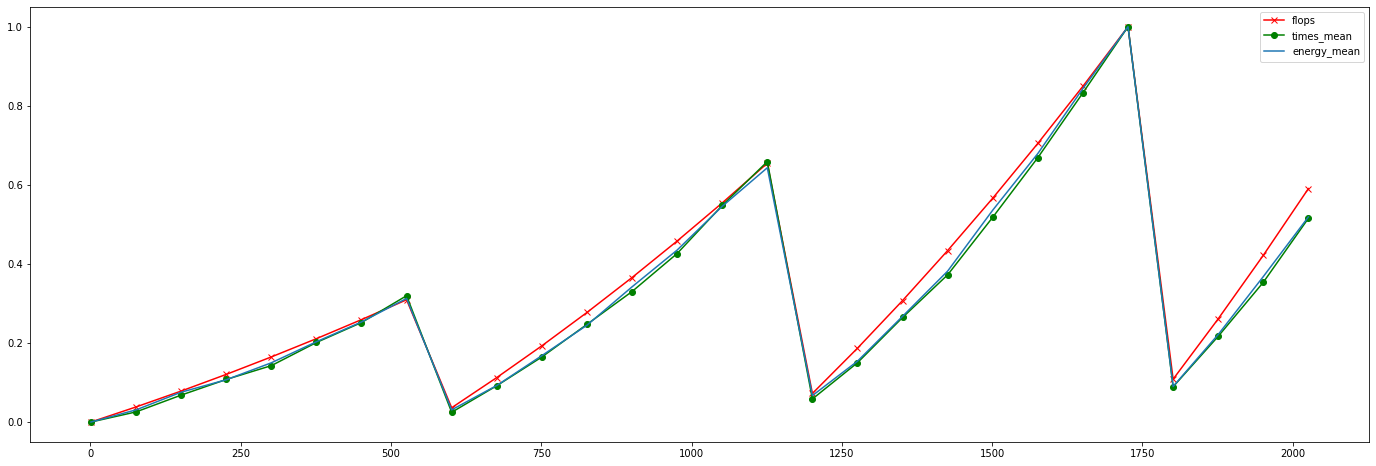

In [76]:
md=module_data.loc[module_data['level_name'] == "encoder.layer.0.attention.self:BertSelfAttention"]
x = md[['flops', 'times_mean', 'energy_mean']].to_numpy() #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
md[['flops', 'times_mean', 'energy_mean']] = x_scaled
md[['flops', 'times_mean', 'energy_mean']].plot(style=['rx-','go-'], figsize=(24, 8))


<AxesSubplot:>

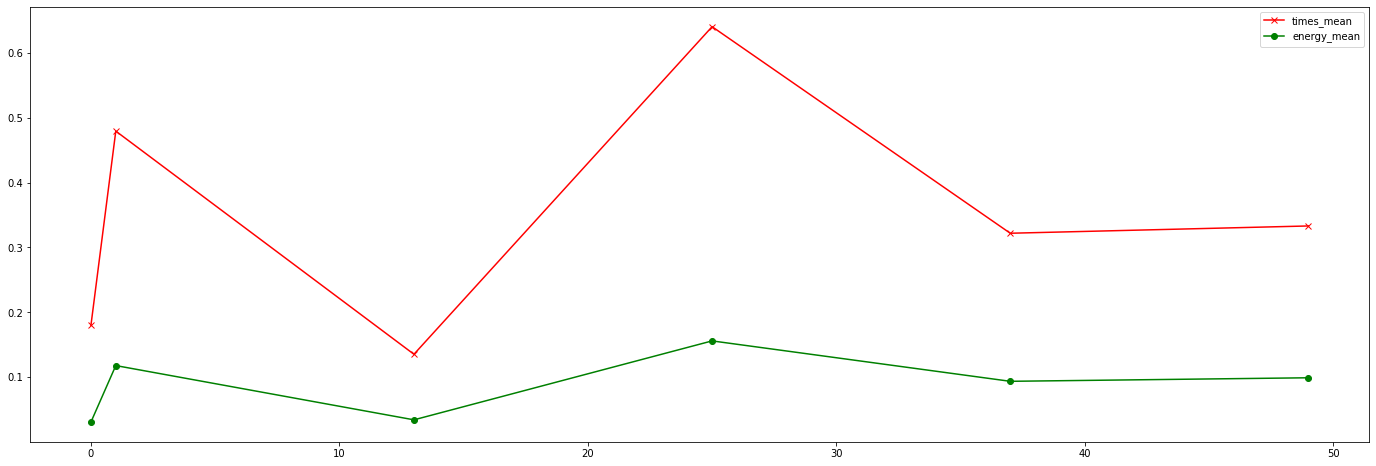

In [50]:
md['times_mean']=module_data[:75]['times_mean'].mul(1000)
md.iloc[[0, 1, 13,25,37,49]][['times_mean', 'energy_mean']].plot(style=['rx-','go-'], figsize=(24, 8))

In [34]:
ml_data

,batch_size,seq_len,flops,mem_bytes,cpu,mem,gpu,gpu_mem,gpu_clk,gpu_mem_clk,times_mean,gpu_energy_mean,energy_mean,level_name,model_name
0,8.000000,32.000000,0.000000,0.751953,8.550000,10.000000,46.955357,17.098214,1911.000000,3802.000000,0.000026,0.002376,0.004968,embeddings.word_embeddings:Embedding,bert-base-uncased
1,8.000000,32.000000,0.000000,0.093994,8.543363,10.000000,12.725664,0.000000,1753.778761,3802.000000,0.000026,0.001282,0.003915,embeddings.position_embeddings:Embedding,bert-base-uncased
2,8.000000,32.000000,0.000000,0.751953,8.550000,10.000000,46.955357,17.098214,1911.000000,3802.000000,0.000026,0.002376,0.004968,embeddings.token_type_embeddings:Embedding,bert-base-uncased
3,8.000000,32.000000,1.572864,3.000000,8.501770,10.000000,53.805310,15.000000,1901.336283,3802.000000,0.000027,0.002558,0.005318,embeddings.LayerNorm:LayerNorm,bert-base-uncased
4,8.000000,32.000000,1.572864,3.000000,8.501770,10.000000,53.805310,15.000000,1901.336283,3802.000000,0.000027,0.002558,0.005318,encoder.layer.0.attention.output.LayerNorm:Lay...,bert-base-uncased
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12736,32.000000,96.000000,1.622016,0.781250,8.560526,10.000000,25.000000,0.000000,1582.000000,3802.000000,0.000052,0.002404,0.007719,h.1.multi_head_attention.Wk:Linear,sshleifer/tiny-ctrl
12737,32.000000,96.000000,1.622016,0.781250,8.560526,10.000000,25.000000,0.000000,1582.000000,3802.000000,0.000052,0.002404,0.007719,h.1.multi_head_attention.Wv:Linear,sshleifer/tiny-ctrl
12738,32.000000,96.000000,1.622016,0.781250,8.560526,10.000000,25.000000,0.000000,1582.000000,3802.000000,0.000052,0.002404,0.007719,h.1.multi_head_attention.dense:Linear,sshleifer/tiny-ctrl
12739,32.000000,96.000000,0.202752,0.261719,8.526087,10.000000,22.000000,0.000000,1582.000000,3802.000000,0.000052,0.002312,0.007625,h.1.ffn.0:Linear,sshleifer/tiny-ctrl


In [16]:
ml_np_data

,batch_size,seq_len,flops,mem_bytes,cpu,mem,gpu,gpu_mem,times_mean,gpu_energy_mean,energy_mean,energy_std_percent,level_name,model_name
0,8,32,12.582912,1.875000,8.563158,10.000000,92.929825,1.000000,19.365540,0.003355,0.006322,0.000000,encoder.layer.0.attention.self:MatMul,bert-base-uncased
1,8,32,12.582912,1.875000,8.563158,10.000000,92.929825,1.000000,19.365540,0.003355,0.006322,0.000000,encoder.layer.0.attention.self:MatMul,bert-base-uncased
2,8,32,12.582912,1.875000,8.563158,10.000000,92.929825,1.000000,19.365540,0.003355,0.006322,0.000000,encoder.layer.1.attention.self:MatMul,bert-base-uncased
3,8,32,12.582912,1.875000,8.563158,10.000000,92.929825,1.000000,19.365540,0.003355,0.006322,0.000000,encoder.layer.1.attention.self:MatMul,bert-base-uncased
4,8,32,12.582912,1.875000,8.563158,10.000000,92.929825,1.000000,19.365540,0.003355,0.006322,0.000000,encoder.layer.2.attention.self:MatMul,bert-base-uncased
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,16,96,4.718592,1.312500,8.507500,10.000000,37.458333,5.933333,20.331659,0.002012,0.004907,0.000000,h.0.multi_head_attention:MatMul,sshleifer/tiny-ctrl
2834,16,96,4.718592,1.312500,8.507500,10.000000,37.458333,5.933333,20.331659,0.002012,0.004907,0.000000,h.1.multi_head_attention:MatMul,sshleifer/tiny-ctrl
2835,16,96,4.718592,1.312500,8.507500,10.000000,37.458333,5.933333,20.331659,0.002012,0.004907,0.000000,h.1.multi_head_attention:MatMul,sshleifer/tiny-ctrl
2836,16,96,1.474560,3.375000,8.533913,10.000000,74.400000,61.947826,19.446709,0.001969,0.003568,0.000000,h.0.multi_head_attention:Softmax,sshleifer/tiny-ctrl


In [ ]:
import torch
cuda_exist = torch.cuda.is_available()
device = torch.device("cuda" if cuda_exist else "cpu")

In [ ]:
module_info = get_module_info('bert-base-uncased', 24, 32, device, 'module')
print_info(module_info)

In [ ]:
ml_info = get_module_info('bert-base-uncased', 24, 32, device, 'ml')
print_info(ml_info)

In [ ]:
ml_info

In [ ]:
ml_np_info = get_module_info('bert-base-uncased', 24, 32, device, 'ml-np')
print_info(ml_np_info)

In [ ]:
ml_np_info

from transformers import AutoModel
from transformers import AutoConfig
import torch
from torch import nn
from calibrate_e_ml import get_module_info
from calibrate_e_ml import print_info
from calibrate_e_ml import is_ml_operation
torch.set_grad_enabled(False)


#load model-energy csv file

for each row:
    # get batch size, seq len, model_name # e.g. bs=24, seq_len=32, model_name='bert-base-uncased'
    device = torch.device("cpu")
    
    ml_info = get_module_info('bert-base-uncased', 24, 32, device, 'ml') # the get_module_info is in calibrate_e_ml.py 
    ml_np_info = get_module_info('bert-base-uncased', 24, 32, device, 'ml-np')
    module_info = get_module_info('bert-base-uncased', 24, 32, device, 'module')
    
    config = AutoConfig.from_pretrained('bert-base-uncased')
    config.torchscript = True
    model=AutoModel.from_config(config).eval()
    
    for name, module in model.named_modules():
        if not name:
            continue
        if not is_ml_operation(module):
            print(f'{name}:{module.__class__.__name__}')
            # use name to get all ml level components from ml_info and ml_np_info
            # for each level, look up the predicted energy using the key: name+flops+mem_bytes


In [ ]:
seq_len = 100
bs = 4
input_ids = torch.randint(1000, size=(bs, seq_len), dtype=torch.long, device='cpu')
config = AutoConfig.from_pretrained("albert-base-v2")
config.torchscript = True
model=AutoModel.from_config(config).eval()
traced_model = torch.jit.trace(model, (input_ids, ))


In [ ]:
trace_graph

In [ ]:
trace_graph = traced_model.inlined_graph
graph, _ = construct_aggregation_graph(trace_graph, 'module_name')

In [ ]:
graph

In [ ]:
module = None
for m in model.modules():
    if m.__class__.__name__ == 'BartAttention':
        module = m
        break

In [ ]:
module

In [ ]:
module.device

In [7]:
from experiment_impact_tracker.utils import gather_additional_info
from experiment_impact_tracker.utils import load_initial_info

loading region bounding boxes for computing carbon emissions region, this may take a moment...
 454/454... rate=459.93 Hz, eta=0:00:00, total=0:00:00, wall=16:01 ESTT
Done!


In [8]:
log_dir = 'data/soft/soft-model-exp-qpc-bert-base-uncased/'
sys_data = load_initial_info(log_dir)
eff_data = gather_additional_info(sys_data, log_dir)

/Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/experiment_impact_tracker/data_utils.py:26: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  return json_normalize(json_array, max_level=max_level), json_array


In [9]:
eff_data

{'cpu_hours': 0.011522222222222224,
 'gpu_hours': 0.012841860913347313,
 'estimated_carbon_impact_kg': 0.0005686162510141881,
 'total_power': 0.00267523815381148,
 'kw_hr_gpu': 0.0010413677640570536,
 'kw_hr_cpu': 0.0006518209408869213,
 'exp_len_hours': 0.009165858891275193}

In [94]:
from datetime import datetime


In [95]:
datetime.fromtimestamp(1611630466.306401)

datetime.datetime(2021, 1, 25, 22, 7, 46, 306401)

In [96]:
import time

dt = datetime.strptime('2021-01-27 02:00:00', '%Y-%m-%d %H:%M:%S')
time.mktime(dt.timetuple())

1611730800.0

In [97]:
1611730800.0 - 1611630656.506736

100143.49326395988